<a href="https://colab.research.google.com/github/MikeFan1433/120-Data-Science-Interview-Questions/blob/master/Uplift_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uplift Marketing Case Study - Retention Campaign Analysis

**1. Background:**
* The firm wishes to enhance its current campaign strategy to target only the clients who are more likely to retain and avoid wasting resources to contact those who will not generate value against the campaign.

* The firm used to do some previous campaigns in the last 3 years (2022 - 2024) and collected the treatment & client behavior data before and after the offer.

* Based on historical campaign results, there was only 30% retention rate in the existing clients got treated (client who transferred mostly their assets to OFI and reduced their trading with the bokerage). Besides, the offers were sent to some clients who did not intended to exit but just temperoraily transfered out their assets for other purposes. Those clients were loyal clients and seems do not need extra incentive to keep relationship with the firm.

**2. Objective:**

Design a targeted campaign strategy to optimize the current retention campaign and maximize the campaign ROI.

**3. Use Cases:**

Help the campaign & marketing team select the target clients who tend to have higher likelihood of retain again the offer and decide the best reach out channel (email, phone channel, App push) to reach out to the client.

The channels used to send the targeted offer to the clients are:

1) Personalized email: Email with the offer detail and registration link;

2) In-app notification: Send the App Notification to clients with the campaign offer; the client can join the camoaign when clicking the notification;

3) Direct Call: ask the branch manager to call their clients with the campaign detail and help them to join.


#### 4. Import the package and create simulated data

In [3]:
# 1.1 Import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import causalml
from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from xgboost import XGBRegressor

# Create simulated data
from causalml.dataset import make_uplift_classification

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [4]:
 #%pip install causalml

In [5]:
# 1.2 Generate Synthetic Data

# Dictionary specifying the number of features that will have a positive effect on retention for each treatment
n_uplift_increase_dict = {
    "email_campaign": 2,
    "in_app_notification": 2,
    "call_campaign": 3
}

# Dictionary specifying the number of features that will have a negative effect on retention for each treatment
n_uplift_decrease_dict = {
    "email_campaign": 2,
    "in_app_notification": 1,
    "call_campaign": 1
}

# Dictionary specifying the magnitude of positive effect on retention for each treatment
delta_uplift_increase_dict = {
    "email_campaign": 0.03,
    "in_app_notification": 0.05,
    "call_campaign": 0.10  # Direct calls have a strong positive effect
}

# Dictionary specifying the magnitude of negative effect on retention for each treatment
delta_uplift_decrease_dict = {
    "email_campaign": 0.04,  # Email campaign might slightly decrease retention for some customers
    "in_app_notification": 0.02,
    "call_campaign": 0.03
}

# Dictionary specifying the number of mixed features (combination of informative and positive uplift) for each treatment
n_uplift_increase_mix_informative_dict = {
    "email_campaign": 1,
    "in_app_notification": 2,
    "call_campaign": 1
}

# Dictionary specifying the number of mixed features (combination of informative and negative uplift) for each treatment
n_uplift_decrease_mix_informative_dict = {
    "email_campaign": 1,
    "in_app_notification": 1,
    "call_campaign": 1
}

positive_class_proportion = 0.4  # Baseline retention rate

# Generate the dataset
df, feature_names = make_uplift_classification(
    n_samples=100000,  # Increased sample size for more robust results
    treatment_name=['email_campaign', 'in_app_notification', 'call_campaign','control'],
    y_name='retention',
    n_classification_features=5,  # Increased number of features
    n_classification_informative=5,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict=delta_uplift_increase_dict,
    delta_uplift_decrease_dict=delta_uplift_decrease_dict,
    n_uplift_increase_mix_informative_dict=n_uplift_increase_mix_informative_dict,
    n_uplift_decrease_mix_informative_dict=n_uplift_decrease_mix_informative_dict,
    positive_class_proportion=positive_class_proportion,
    random_seed=100
)

#Encoding treatments variables
encoding_dict = {
    'call_campaign': 3,
    'email_campaign': 1,
    'in_app_notification':2,
    'control': 0
}

# Create a new column with encoded values
df['treatment_group_numeric'] = df['treatment_group_key'].map(encoding_dict)

In [6]:
df.sample(5)

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_uplift_increase,x7_uplift_increase,x8_increase_mix,x9_uplift_increase,...,x17_uplift_decrease,x18_uplift_decrease,x19_decrease_mix,x20_uplift_decrease,x21_decrease_mix,x22_uplift_decrease,x23_decrease_mix,retention,treatment_effect,treatment_group_numeric
71114,in_app_notification,-1.935806,0.457253,1.243518,1.702409,-0.510234,0.897107,1.176117,-1.632043,-1.761609,...,2.522613,0.897454,1.072304,-0.093545,-1.166665,-0.930518,1.564206,0,0,2
48011,email_campaign,0.464215,-1.285599,0.277031,4.262988,0.330102,0.922007,-0.821695,-3.297698,-1.601276,...,-0.604257,-0.878543,1.662717,-1.164389,-3.065783,-0.268805,1.964256,1,1,1
71164,in_app_notification,0.336375,-1.000663,-0.963410,-0.236293,-1.018680,0.575548,1.397532,-0.190568,-1.048868,...,-0.761543,-1.072980,-0.459050,-1.615106,-0.090728,-1.042911,0.893183,0,0,2
254170,in_app_notification,-0.727054,-1.694896,0.187788,0.455107,-0.725424,0.585202,1.401538,-0.642069,-2.747769,...,0.119417,-1.165670,-0.173091,0.148877,-0.284901,-1.079832,1.205435,0,0,2
127569,control,1.121904,-1.495226,-0.794855,0.612541,-0.195795,0.104221,1.862624,-0.457003,-1.814088,...,0.361483,-2.689718,-0.599573,-0.773248,-0.534551,-0.810468,1.013405,0,0,0


#### Data Interpretation:
The sythetic data created above simulates the real life cases.

* x_1 to x_23 represents the individual aggregated activity & transfer and demographic features (numeric and categorical) before receiving the campaign.
Those covariates should be used to identify the typical client and actionable for targeted marketing.

  * Sample Features: Gender, Tenure, Age, Acquisition Channel, Avg Trading Frequency, Avg Trading Volume, Avg Net Transfer-In.  

* The "treatment_group_key" and "treatment_group_numeric" columns represent whether the client received the campaign or not (control).
  * The treatment could be randomly assigned or based on some criteria.

* Retention is the outcome indicating whether the client retained or not.

* If the campaign data is not from controlled experiments and not random, there could be selection bias if directly used. The data should be de-baised using techniques like PSM first then to be used for model training.


#### 5. Data Preparation

Here the data is split into the Training and Testing groups for 2 analysis:

1. Single treatment case, focusing on a single retention strategy: sending email to our customers. The goal is to identify the most responsive clients to be contacted with targeted campaign email.

2. Second treatment case: a multi treatment case, comparing the effectiveness of different treatments and most importantly find the best one for each customer.

In [7]:
# Split the data into train and test datasets for each case:

# 1. Define the data split function
def prepare_data(df, feature_names, y_name, test_size=0.2, random_state=42):
    """
    Prepare data for uplift modeling, including splitting into train and test sets,
    and creating email-treatment subsets.
    """
    # Create binary treatment column
    df['treatment_col'] = np.where(df['treatment_group_key'] == 'control', 0, 1)

    # Split data into train and test sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

    # Create email treatment subsets (only includes email treatment and control groups)
    df_train_email = df_train[df_train['treatment_group_key'].isin(['email_campaign', 'control'])]
    df_test_email = df_test[df_test['treatment_group_key'].isin(['email_campaign', 'control'])]

    # Prepare features, treatment, and target variables for full dataset
    X_train = df_train[feature_names].values
    X_test = df_test[feature_names].values
    treatment_train = df_train['treatment_group_key'].values
    treatment_test = df_test['treatment_group_key'].values
    y_train = df_train[y_name].values
    y_test = df_test[y_name].values

    # Prepare features, treatment, and target variables for email treatment dataset
    X_train_email = df_train_email[feature_names].values
    X_test_email = df_test_email[feature_names].values
    treatment_train_email = df_train_email['treatment_group_key'].values
    treatment_test_email = df_test_email['treatment_group_key'].values
    y_train_email = df_train_email[y_name].values
    y_test_email = df_test_email[y_name].values

    return { # Return the data for both use cases
        'df_train': df_train, 'df_test': df_test,
        'df_train_email': df_train_email, 'df_test_email': df_test_email,
        'X_train': X_train, 'X_test': X_test,
        'X_train_email': X_train_email, 'X_test_email': X_test_email,
        'treatment_train': treatment_train, 'treatment_test': treatment_test,
        'treatment_train_email': treatment_train_email, 'treatment_test_email': treatment_test_email,
        'y_train': y_train, 'y_test': y_test,
        'y_train_email': y_train_email, 'y_test_email': y_test_email
    }


# 2. Prepare the Train and Test data for both use cases:
features = [i for i in df.columns if i not in ['retention', 'treatment_effect', 'treatment_group_numeric','treatment_group_key']]
data = prepare_data(df = df, feature_names = features, y_name = 'retention')

# Print shapes for verification
print(f"Full test set shape: {data['df_test'].shape}")
print(f"Email treatment test set shape: {data['df_test_email'].shape}")

# 3. Access prepared data
df_train, df_test = data['df_train'], data['df_test']
df_train_email, df_test_email = data['df_train_email'], data['df_test_email']
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
X_train_email, y_train_email = data['X_train_email'], data['y_train_email']
X_test_email, y_test_email = data['X_test_email'], data['y_test_email']
treatment_train, treatment_test = data['treatment_train'], data['treatment_test']
treatment_train_email, treatment_test_email = data['treatment_train_email'], data['treatment_test_email']

Full test set shape: (80000, 28)
Email treatment test set shape: (40133, 28)


In [8]:
data['df_train_email'].head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_uplift_increase,x7_uplift_increase,x8_increase_mix,x9_uplift_increase,...,x18_uplift_decrease,x19_decrease_mix,x20_uplift_decrease,x21_decrease_mix,x22_uplift_decrease,x23_decrease_mix,retention,treatment_effect,treatment_group_numeric,treatment_col
288918,control,-0.271274,-1.774835,1.679339,0.619861,0.152304,0.916350,1.389114,-0.945583,-1.784827,...,-1.185603,-0.104245,-1.459662,-0.646029,-0.828436,1.033361,1,0,0,0
105103,email_campaign,0.624453,-0.114331,-0.077018,1.720185,0.686196,0.278609,1.832659,-1.275006,0.250111,...,-1.334508,0.350386,-0.679672,-1.269655,-1.475968,2.088037,1,0,1,1
11328,control,2.692538,-1.894338,4.697273,-0.832874,-0.078633,0.645874,1.299523,0.152151,0.363315,...,-1.435863,-0.850648,-0.110058,0.546589,-0.648901,0.280687,1,0,0,0
386155,control,-0.804751,-2.420751,0.663913,0.933000,-1.029842,0.524696,1.211426,-0.914121,-2.448468,...,-0.563131,0.242602,-0.186388,-0.660356,-0.624715,0.965958,0,0,0,0
37244,control,-1.249268,-0.839145,-0.096909,-1.209741,-0.911296,1.326402,0.549460,-0.010334,-1.396681,...,-1.305281,-0.980331,-1.653617,0.562100,-1.531831,0.965945,0,0,0,0


#### 6. Uplift Modeling

The goal of the model is to learn from the previous treatment data and identify the most responsive clients with the offer.

Model Selection:
* Uplift Random Forest
* S-Learner
* T-Learner
* X-Learner

Model Assumptions:

1. Unconfoundness (Ignorability): there should be no unseen confounders except for the covariates controlled;
2. Positivity: both the units in the treatment and control group should have some likelihood of getting the treatment;
3. Consistency (SUTVA): the treatment is consistent to all unit assigned and one client's behaviour should not be affected by the treatment assigned to another client.  

#### 6.1 Email Treatment Use Case
Triain the models with the Email Treatment data on the training set and validate the result in the testing set.

Even though the outcome metric is binary (1 ~ if the client retained, 0 ~ if the client left), using Regressor is better than Classifier, for the 3 reasons below:

  **1. Flexibility:** the regressor aims for estimating individual treatment effects (ITE) - the **difference of retention probability** between the treatment and control groups, which makes it easier to compute the uplift.

  **2. Optimization:** Regressors, use gradient-based optimization can provide more stable and continuous updates during training. Since uplift modeling is about predicting the magnitude of the effect, having a more flexible gradient-based approach is useful for improving the quality of uplift predictions.

  3**. Avoid Thresholding:** Classifiers often require a decision threshold to classify an outcome. This can create problems when you're focused on calculating the uplift, which is a more nuanced metric requiring precise probability estimates for both the treated and control groups. A regressor directly predicts probabilities without imposing a hard threshold, making it more suitable for uplift modeling.


  #### 6.1.1 Model Training

In [9]:
#save results in a df
df_results_email = df_test_email.copy()

# Model 1 - Uplift Random Forest
# Initialize and train a Random Forest Classifier
rfc = UpliftRandomForestClassifier(control_name='control')
rfc.fit(X_train_email, treatment_train_email, y_train_email)


# Model 2 - S-learner
# Initialize and train S-Learner
learner_s = BaseSRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_s.fit(X_train_email, treatment_train_email, y_train_email)


# Model 3 - T-learner
# Initialize and train T-Learner
learner_t = BaseTRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_t.fit(X_train_email, treatment_train_email, y_train_email)


# Model 4 - X-learner
learner_x = BaseXRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_x.fit(X_train_email, treatment_train_email, y_train_email)


# Predict treatment effects
df_results_email[["email_S_learner"]] = learner_s.predict(X=X_test_email)
df_results_email[["email_T_learner"]] = learner_t.predict(X=X_test_email)
df_results_email[["email_X_learner"]] = learner_x.predict(X=X_test_email)
df_results_email["random_forest_learner"] = rfc.predict(X_test_email)

display(df_results_email[["email_S_learner", "email_T_learner", "email_X_learner", "random_forest_learner"]].mean())

df_email_results_plot = df_results_email[["email_S_learner","email_T_learner", "email_X_learner", "random_forest_learner","retention","treatment_col"]].copy()

,0
email_S_learner,0.003998
email_T_learner,0.004778
email_X_learner,0.004285
random_forest_learner,0.004310


In [10]:
df_results_email.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_uplift_increase,x7_uplift_increase,x8_increase_mix,x9_uplift_increase,...,x22_uplift_decrease,x23_decrease_mix,retention,treatment_effect,treatment_group_numeric,treatment_col,email_S_learner,email_T_learner,email_X_learner,random_forest_learner
23218,email_campaign,0.705919,-0.730625,-0.228107,1.614057,1.340919,1.641891,0.490176,-2.018819,-1.270643,...,-0.314552,0.945272,1,0,1,1,-0.007534,-0.040303,-0.021545,-0.021510
20731,email_campaign,2.140991,-1.221127,0.800327,0.975001,0.662605,1.595264,0.590239,-1.579036,-0.776468,...,-0.473397,0.839459,1,0,1,1,-0.005422,0.010361,-0.049346,-0.012033
190913,control,1.076314,-0.245151,-1.240220,1.043222,1.212847,1.240004,0.515110,-1.411357,-1.281700,...,-0.923913,1.293590,0,0,0,0,-0.007534,0.018451,0.021246,-0.016732
49119,control,0.798832,-1.106433,1.167739,0.854121,1.898437,0.396754,1.932364,-0.787040,-1.477479,...,-1.018900,1.307734,1,0,0,0,-0.005938,-0.016704,-0.042846,-0.021851
208005,control,-1.000882,-1.471392,0.681647,0.334419,-2.408667,2.919486,-0.536307,-1.955011,-0.154613,...,1.437459,-1.227585,0,0,0,0,0.046123,-0.021220,0.033220,0.053921


The email_S_learner,	email_T_learner,	email_X_learner,	random_forest_learner columns indicate the estimated treatment effect of each client in the testing set. The negative value indicates there is negative effect if we contact the client with the email offer, and the positive value indicates sending the campaign to the client can increase the retention likelihood.

#### 6.1.2 Model Evaluation & Selection

Since we do not know the true Individual Treatment Effect (ITE) of each client in reality, we cannot use the normal evaluation approaches used in the traditional machine learning sector.

The Uplift Curve (Gain Curve), Qini Curve and AUCC are the methods to be used for model evaluation.

The uplift curve is used to demonstrate the enhancement of the treatment effect if reaching out the clients based on their scores by the model with random reach out. The higher the uplift gain curve against the random gain curve, the better the model performance.

Qini Curve and Qini Score are another useful uplift model evaluation metrics as the adaption of Gain Curve, with the adding comparison to the random model.

The AUCC is like AUC, which measures the Area under the gain curve of our model, enabling us to compare it with the one of the random model.

In [11]:
from causalml.metrics import plot_gain
from causalml.metrics import auuc_score

from causalml.metrics import plot_qini
from causalml.metrics import qini_score

In [12]:
df_email_results_plot.head()

,email_S_learner,email_T_learner,email_X_learner,random_forest_learner,retention,treatment_col
23218,-0.007534,-0.040303,-0.021545,-0.021510,1,1
20731,-0.005422,0.010361,-0.049346,-0.012033,1,1
190913,-0.007534,0.018451,0.021246,-0.016732,0,0
49119,-0.005938,-0.016704,-0.042846,-0.021851,1,0
208005,0.046123,-0.021220,0.033220,0.053921,0,0


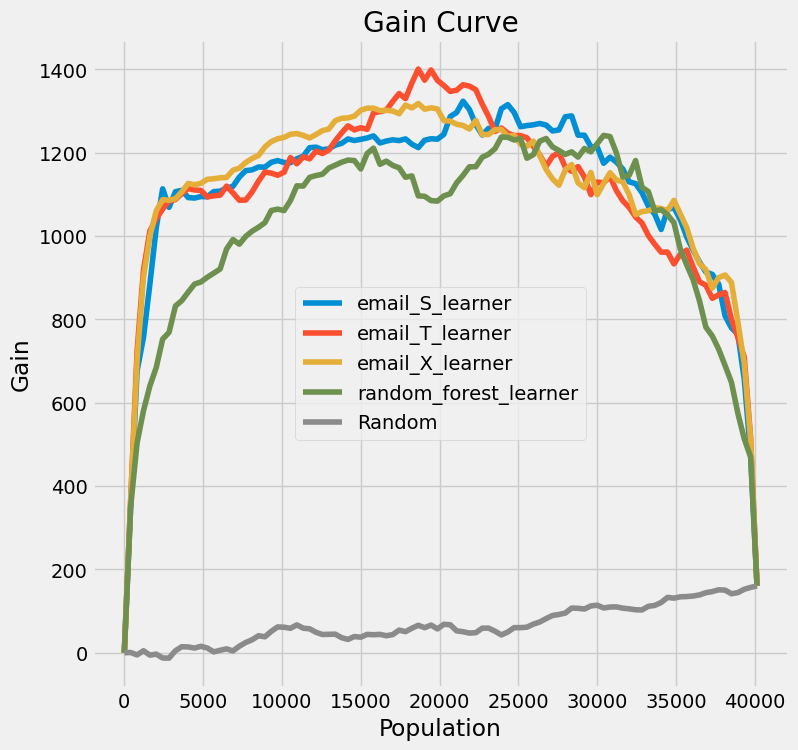

In [13]:
# 1. Plot the Gain Curve for each model
plot_gain(df_email_results_plot, outcome_col='retention', treatment_col='treatment_col')
plt.title('Gain Curve')
plt.show()

In [14]:
# 2. Plot the AAUC scores for each model
aauc_normalized = auuc_score(df_email_results_plot, outcome_col='retention', treatment_col='treatment_col', normalize=True, tmle=False)
print(f"AAUC Score Normalized: \n{aauc_normalized}")

AAUC Score Normalized: 
email_S_learner          6.984817
email_T_learner          6.965406
email_X_learner          7.046514
random_forest_learner    6.384248
Random                   0.415120
dtype: float64


From the Uplift Gain Curve it can be conclude that all uplift models outperform the random model hugely which indicates we are able to retain more customers without the need to reach out bigger population, which saves time and marketing resources.

From the Uplift Gain Curve, we can found that if we randomly reach out the entire client population, we would only retain additional 200 clinets. However, if we reaching out to only half of the population, we are able to retain additional 1000 clients. The models achieved this by reaching out only to the clients with positive response and ignoring those who will respond negatively (e.g. churn) to the campaign.


From the AAUC table, X-learner derived the highest score indicating the best performance among all other models.

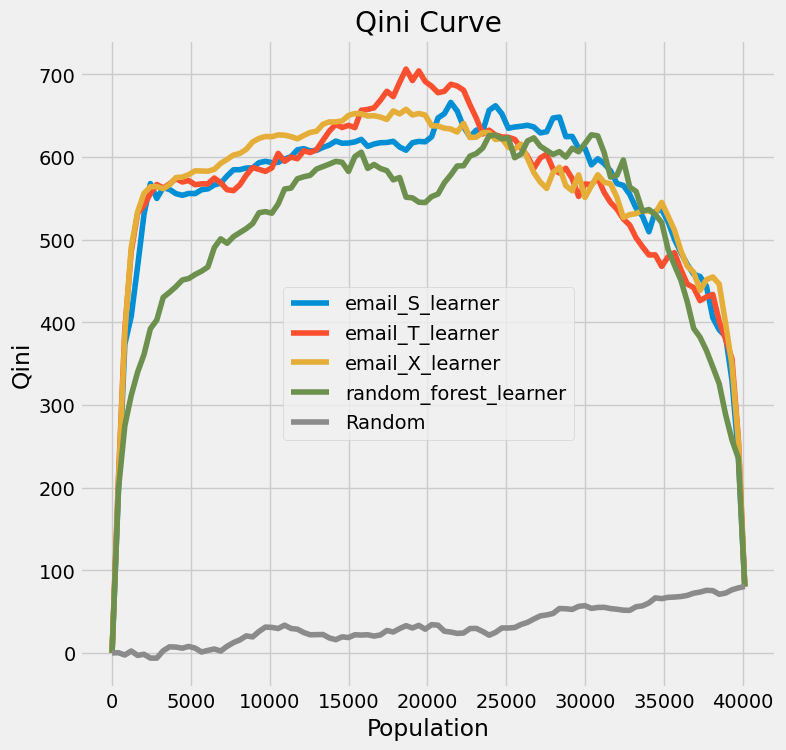

In [15]:
# 3. Plot the Qini Curve for the models
plot_qini(df_email_results_plot, outcome_col='retention', treatment_col='treatment_col')
plt.title('Qini Curve')
plt.show()

In [16]:
# 4. Plot the Qini Scores
qini_normalized = qini_score(df_email_results_plot, outcome_col='retention', treatment_col='treatment_col', normalize=True, tmle=False)
print(f"Qini Score Normalized: \n{aauc_normalized}")

Qini Score Normalized: 
email_S_learner          6.984817
email_T_learner          6.965406
email_X_learner          7.046514
random_forest_learner    6.384248
Random                   0.415120
dtype: float64


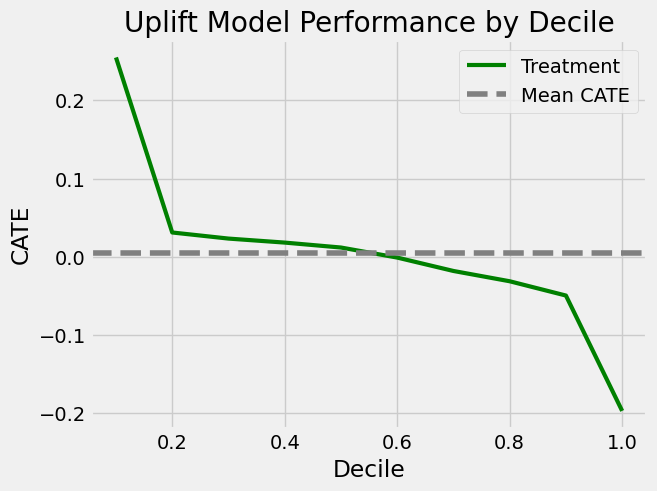

In [17]:
# Make the CATE decile plot across the deciles of clients by their estimated uplift scores, using X-Learner result
cate_plot_df = df_email_results_plot[['email_X_learner', 'retention', 'treatment_col']].rename({'email_X_learner':'uplift'}, axis = 1)

# Add decile groups based on uplift scores
cate_plot_df['decile'] = pd.qcut(cate_plot_df ['uplift'], q=10, labels=False)

# Calculate the average CATE per decile
decile_avg = cate_plot_df.groupby('decile').mean()

# Calculate the overall average CATE
mean_cate = cate_plot_df['uplift'].mean()

# Plot the CATE for each decile
plt.plot(np.arange(1,0,-0.1), decile_avg['uplift'], label='Treatment', linewidth=3, color='green')
plt.axhline(mean_cate, color='gray', linestyle='--', label='Mean CATE')

# Customize the plot
plt.xlabel('Decile')
plt.ylabel('CATE')
plt.title('Uplift Model Performance by Decile')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Print out the detail of CATE by decile
decile_avg['overall CATE'] = mean_cate
decile_avg

,uplift,retention,treatment_col,overall CATE
decile,,,,
0,-0.196868,0.714998,0.506976,0.004285
1,-0.049453,0.861450,0.497882,0.004285
2,-0.031197,0.905059,0.500374,0.004285
3,-0.018054,0.791677,0.502616,0.004285
4,-0.000935,0.272546,0.511460,0.004285
5,0.011904,0.063294,0.500872,0.004285
6,0.018214,0.025417,0.486170,0.004285
7,0.023334,0.024171,0.488413,0.004285
8,0.031118,0.027909,0.510092,0.004285


The plot above represents the change of CATE scores ranked by the decile of clients from high to low.Decile 1 (10%) has the highest CATE and decile 10 (100%) has the lowest.

As can be seen from the decile CATE plot and details above, the CATE (Uplift treatment effect) starts to decrease to around 0 at top 20% of clients ranked by their uplift score. The mean CATE is only 0.004, so for practical marketing decision-making, we can only focus on targeting the top 20% clients (2 decile) by their CATE, who have the highest uplift when reaching out (persuadable) than the rest of clients (sure things, lose causes).

The clients with negative CATE scores (6-10 decile) are sleeping dogs and we should aviod reaching out to them.

#### 6.2 Multi-Channel Use Case

how can we personalize our approach to every customer with the best channel.

The models below is trained on all the data with multiple channels and are used to evaluate the channel impact to each client and suggest the best channel to reach out them.

The channel list is:
* Email campaign
* Call campaign
* In-app notification

#### 6.2.1 Model Training

In [19]:
#save results in a df
df_results_multi = df_test.copy()

# Define treatment actions
actions = ['call_campaign', 'email_campaign', 'in_app_notification']

# Initialize and train Uplift Random Forest Classifier
rfc = UpliftRandomForestClassifier(

    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    min_samples_treatment=10,
    n_reg=10,
    control_name='control',
    random_state=42
)

rfc.fit(X_train , treatment_train, y_train)

# Initialize and train S-Learner
learner_s = BaseSRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_s.fit(X_train , treatment_train, y_train)

# Initialize and train T-Learner
learner_t = BaseTRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_t.fit(X_train , treatment_train, y_train)

# Initialize and train X-Learner
learner_x = BaseXRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_x.fit(X_train , treatment_train, y_train)

#### 6.1.2 Model Evaluation & Selection

Based on the test set, use the same metrices above. Given each model will output the estimated CATE of each channel for each client, for model selection, first we need to pick up the channel to each client which has the highest CATE, then record the CATE score. Then compare the CATE scores of all models.

In [22]:
def predict_multi(df, learner, learner_name, X_test):
    """
    Predict treatment effects for multiple treatments and determine the best treatment based on the highest estimated CATE score.
    """

    # Predict treatment effects
    cols = [f'{learner_name}_learner_{action}' for action in actions]
    df[cols] = learner.predict(X=X_test)

    # Determine the best treatment effect
    df[f'{learner_name}_learner_best_effect'] = df[cols].max(axis=1)

    # Determine the best treatment
    df[f"{learner_name}_best_treatment"] = df[cols].idxmax(axis=1)
    df.loc[df[f'{learner_name}_learner_best_effect'] < 0, f"{learner_name}_best_treatment"] = "control"

    return df

# Apply predictions for each model
df_results_multi = predict_multi(df_results_multi, rfc, 'rf', X_test)
df_results_multi = predict_multi(df_results_multi, learner_s, 's', X_test)
df_results_multi = predict_multi(df_results_multi, learner_t, 't', X_test)
df_results_multi = predict_multi(df_results_multi, learner_x, 'x', X_test)

# Priint the mean CATE for each model after determining the channel for each client
display(df_results_multi[["s_learner_best_effect", "t_learner_best_effect", "x_learner_best_effect", "rf_learner_best_effect"]].mean())

,0
s_learner_best_effect,0.140087
t_learner_best_effect,0.167335
x_learner_best_effect,0.157406
rf_learner_best_effect,0.105999


From the Average CATE scores of the models above on testing set, we can conclude that the multi-channel treatment strategy can provide higher retention uplift than email channel only.

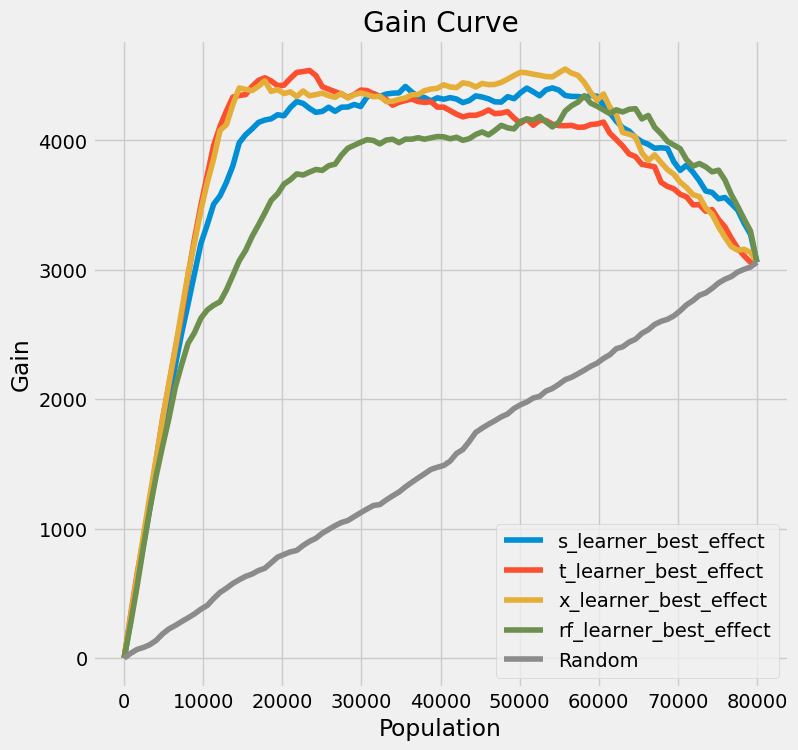

In [23]:
# Plot the Gain Curve for each model
df_learner_plot_multi = df_results_multi[["s_learner_best_effect", "t_learner_best_effect", "x_learner_best_effect", "rf_learner_best_effect", "retention","treatment_col"]].copy()

plot_gain(df_learner_plot_multi , outcome_col='retention', treatment_col='treatment_col')
plt.title('Gain Curve')
plt.show()

In [24]:
# Plot the AAUC scores for each model
aauc_normalized_multi = auuc_score(df_learner_plot_multi, outcome_col='retention', treatment_col='treatment_col', normalize=True, tmle=False)
aauc_multi = auuc_score(df_learner_plot_multi, outcome_col='retention', treatment_col='treatment_col', normalize=False, tmle=False)

print(f"AAUC Score Normalized for Multi-Channel: \n{aauc_normalized_multi}")
print("")
print(f"AAUC Score for Multi-Channel: \n{aauc_multi}")

AAUC Score Normalized for Multi-Channel: 
s_learner_best_effect     1.246314
t_learner_best_effect     1.242358
x_learner_best_effect     1.269976
rf_learner_best_effect    1.167468
Random                    0.501560
dtype: float64

AAUC Score for Multi-Channel: 
s_learner_best_effect     3811.171665
t_learner_best_effect     3799.072877
x_learner_best_effect     3883.528227
rf_learner_best_effect    3570.062820
Random                    1533.745609
dtype: float64


From the Uplift Gain Chart and AAUC scores above, we can found that all the models outperform the random model, and X-learner once again did the best job with the highest AAUC score.

Compared with the single email use case, the uplift models are able to output better performance. This can be caused by the bigger size of the training data, or the model itself.

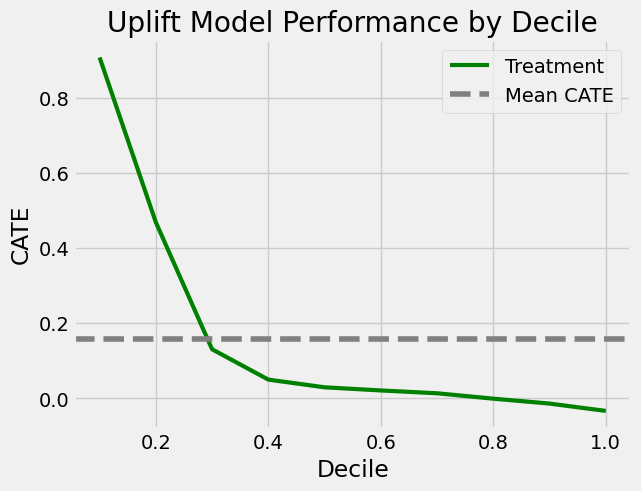

In [25]:
# Make the CATE decile plot across the deciles of clients by their estimated uplift scores, using X-Learner result
cate_plot_df_multi = df_learner_plot_multi[['x_learner_best_effect', 'retention', 'treatment_col']].rename({'x_learner_best_effect':'uplift'}, axis = 1)

# Add decile groups based on uplift scores
cate_plot_df_multi['decile'] = pd.qcut(cate_plot_df_multi['uplift'], q=10, labels=False)

# Calculate the average CATE per decile
decile_avg_multi = cate_plot_df_multi.groupby('decile').mean()

# Calculate the overall average CATE
mean_cate_multi = cate_plot_df_multi['uplift'].mean()

# Plot the CATE for each decile
plt.plot(np.arange(1,0,-0.1), decile_avg_multi['uplift'], label='Treatment', linewidth=3, color='green')
plt.axhline(mean_cate_multi, color='gray', linestyle='--', label='Mean CATE')

# Customize the plot
plt.xlabel('Decile')
plt.ylabel('CATE')
plt.title('Uplift Model Performance by Decile')
plt.legend()
plt.grid(True)
plt.show()

From the decile plot above, the top 60% clients tend to have positive response to the campaign based on the model output. Only the last 20% clients would react negatively to the offer (sleeping dogs).

Therefore, we can used this model output to select the top X% clients as the final target of our campaign with the right channel of reaching out to maximize our ROI.